<a href="https://colab.research.google.com/github/webmasterKY/web1/blob/main/Untitled1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable

batch_size =3

In [2]:
import os

os.environ["CUDA_VISIBLE_DEVICES"]="0"

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable

import torch.nn.functional as F
from skimage.transform import resize
import matplotlib.pyplot as plt
%matplotlib inline  

import random

In [3]:
batch_size = 256
learning_rate = 0.0001
num_epoch = 10
def one_sided_padding(x):
    rand1 = random.randrange(0,15,3)
    rand2 = random.randrange(0,15,3)

    zero = np.zeros(shape=[28,28,1])
    zero[rand1:rand1+12,rand2:rand2+12,:]=np.asarray(x).reshape(12,12,1)
    return zero

In [4]:
mnist_train = dset.KMNIST("./", train=True, 
                         transform=transforms.Compose([
                            transforms.RandomCrop(22),
                            transforms.Resize(12),
                            transforms.Lambda(one_sided_padding),
                            transforms.ToTensor(),
                         ]), 
                         target_transform=None, 
                         download=True)

mnist_test = dset.KMNIST("./", train=False,
                        transform=transforms.Compose([
                            transforms.RandomCrop(22),
                            transforms.Resize(12),
                            transforms.Lambda(one_sided_padding),
                            transforms.ToTensor(),
                        ]),
                        target_transform=None, 
                        download=True)

train_loader = torch.utils.data.DataLoader(mnist_train,batch_size=batch_size, shuffle=True,num_workers=2,drop_last=True)
test_loader = torch.utils.data.DataLoader(mnist_test,batch_size=batch_size, shuffle=True,num_workers=2,drop_last=True)

  0%|          | 0/18165135 [00:00<?, ?it/s]

Extracting ./KMNIST/raw/train-images-idx3-ubyte.gz to ./KMNIST/raw



  0%|          | 0/29497 [00:00<?, ?it/s]

Extracting ./KMNIST/raw/train-labels-idx1-ubyte.gz to ./KMNIST/raw



  0%|          | 0/3041136 [00:00<?, ?it/s]

Extracting ./KMNIST/raw/t10k-images-idx3-ubyte.gz to ./KMNIST/raw



  0%|          | 0/5120 [00:00<?, ?it/s]

Extracting ./KMNIST/raw/t10k-labels-idx1-ubyte.gz to ./KMNIST/raw



In [9]:
class CNN(nn.Module):
    def __init__(self,num_feature=32):
        super(CNN,self).__init__()
        self.num_feature=num_feature
        
        self.layer = nn.Sequential(
            nn.Conv2d(1,self.num_feature,3,1,1),
            nn.BatchNorm2d(self.num_feature),
            nn.ReLU(),
            nn.Conv2d(self.num_feature,self.num_feature*2,3,1,1),
            nn.BatchNorm2d(self.num_feature*2),
            nn.ReLU(),
            nn.AvgPool2d(2,2),
            
            nn.Conv2d(self.num_feature*2,self.num_feature*4,3,1,1),
            nn.BatchNorm2d(self.num_feature*4),
            nn.ReLU(),
            nn.AvgPool2d(2,2),
            
            nn.Conv2d(self.num_feature*4,self.num_feature*8,3,1,1),
            nn.BatchNorm2d(self.num_feature*8),
            nn.ReLU(),
        )
        self.fc_layer = nn.Sequential(
            nn.Linear(self.num_feature*8*7*7,1000),
            nn.ReLU(),
            nn.Linear(1000,10)
        )       
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                
                # Kaming Initialization
                init.kaiming_normal(m.weight.data)
                m.bias.data.fill_(0)
                
            elif isinstance(m, nn.Linear):

                # Kaming Initialization
                init.kaiming_normal(m.weight.data)
                m.bias.data.fill_(0)
        
        
    def forward(self,x):
        x = x.float()
        out = self.layer(x)
        out = out.view(x.size()[0],-1)
        out = self.fc_layer(out)

        return out

model = nn.DataParallel(CNN().cuda())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.


In [10]:
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [11]:
for i in range(num_epoch):
    model.train()
    for j,[image,label] in enumerate(train_loader):
        x = Variable(image).cuda()
        y_= Variable(label).cuda()
        
        optimizer.zero_grad()
        output = model.forward(x)
        loss = loss_func(output,y_)
        loss.backward()
        optimizer.step()
        
         
    top_1_count = torch.FloatTensor([0])
    total = torch.FloatTensor([0])
    model.eval() 
    for image,label in test_loader:
        x = Variable(image,volatile=True).cuda()
        y_= Variable(label).cuda()

        output = model.forward(x)
        
        values,idx = output.max(dim=1)
        top_1_count += torch.sum(y_==idx).float().cpu().data

        total += label.size(0)

    print("Test Data Accuracy: {}%".format(100*(top_1_count/total).numpy()))
    if (top_1_count/total).numpy() > 0.98:
        break


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Test Data Accuracy: [63.641827]%
Test Data Accuracy: [71.394226]%
Test Data Accuracy: [76.492386]%
Test Data Accuracy: [78.6258]%
Test Data Accuracy: [79.78766]%
Test Data Accuracy: [83.673874]%
Test Data Accuracy: [84.84575]%
Test Data Accuracy: [83.203125]%
Test Data Accuracy: [83.95433]%
Test Data Accuracy: [85.48678]%


In [23]:
class CAM():
    def __init__(self,model):
        self.gradient = []
        self.h = model.module.layer[-1].register_backward_hook(self.save_gradient)
        
    def save_gradient(self,*args):
        grad_input = args[1]
        grad_output= args[2]
        self.gradient.append(grad_output[0])
      
    def get_gradient(self,idx):
        return self.gradient[idx]
    
    def remove_hook(self):
        self.h.remove()
            
    def normalize_cam(self,x):
        x = 2*(x-torch.min(x))/(torch.max(x)-torch.min(x)+1e-8)-1
        x[x<torch.max(x)]=-1
        return x
    
    def visualize(self,cam_img,img_var):
        cam_img = resize(cam_img.cpu().data.numpy(),output_shape=(28,28))
        x = img_var[0,:,:].cpu().data.numpy()

        plt.subplot(1,3,1)
        plt.imshow(cam_img)

        plt.subplot(1,3,2)
        plt.imshow(x,cmap="gray")

        plt.subplot(1,3,3)
        plt.imshow(x+cam_img*2)
        plt.show()
    
    def get_cam(self,idx):
        grad = self.get_gradient(idx)
        alpha = torch.sum(grad,dim=3,keepdim=True)
        alpha = torch.sum(alpha,dim=2,keepdim=True)
        
        cam = alpha[j]*grad[j]
        cam = torch.sum(cam,dim=0)
        cam = self.normalize_cam(cam)
        
        self.remove_hook()
        return cam

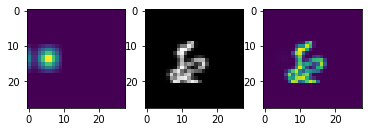

tensor(7, device='cuda:0')


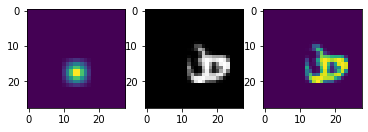

tensor(7, device='cuda:0')


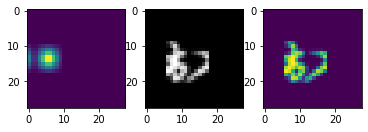

tensor(0, device='cuda:0')


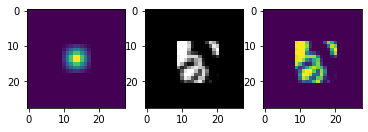

tensor(2, device='cuda:0')


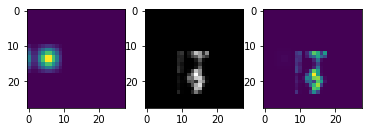

tensor(3, device='cuda:0')


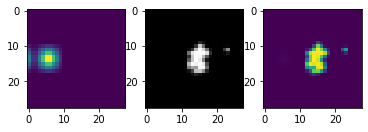

tensor(0, device='cuda:0')


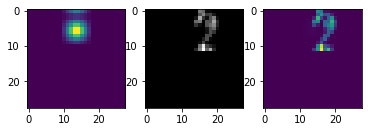

tensor(4, device='cuda:0')


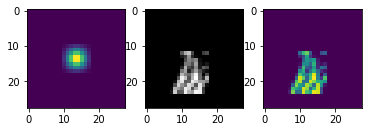

tensor(7, device='cuda:0')


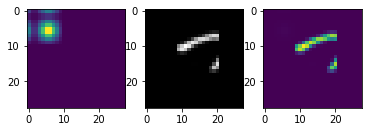

tensor(3, device='cuda:0')


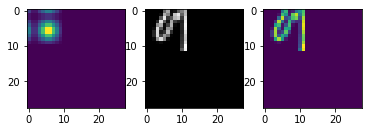

tensor(3, device='cuda:0')


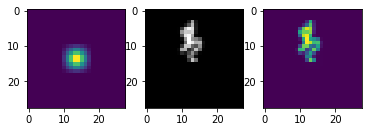

tensor(5, device='cuda:0')


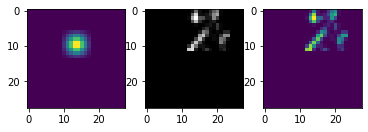

tensor(7, device='cuda:0')


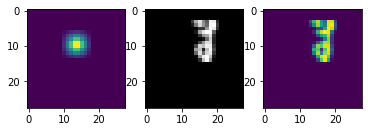

tensor(6, device='cuda:0')


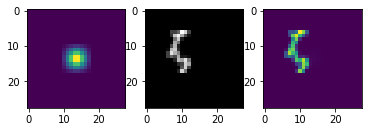

tensor(5, device='cuda:0')


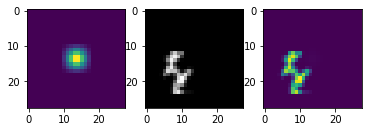

tensor(9, device='cuda:0')


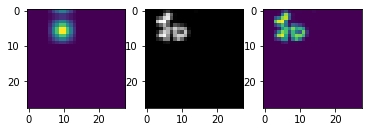

tensor(0, device='cuda:0')


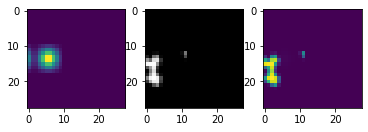

tensor(0, device='cuda:0')


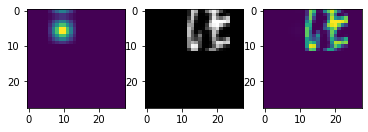

tensor(3, device='cuda:0')


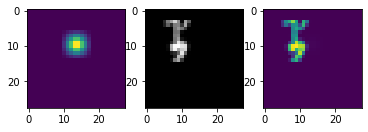

tensor(6, device='cuda:0')


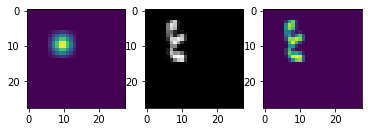

tensor(2, device='cuda:0')


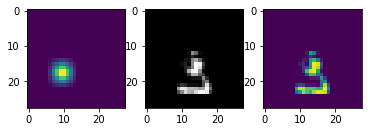

tensor(1, device='cuda:0')


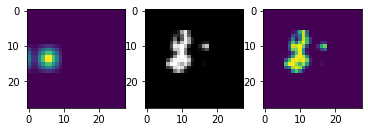

tensor(0, device='cuda:0')


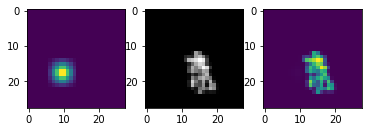

tensor(1, device='cuda:0')


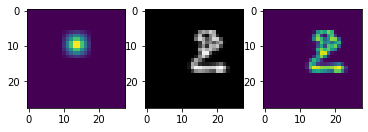

tensor(8, device='cuda:0')


In [45]:
cam = CAM(model)

for i,[image,label] in enumerate(test_loader):
    x = Variable(image).cuda()
    y_= Variable(label).cuda()
        
    output = model.forward(x)    
    
    for j in range(24):
        model.zero_grad()
        lab = y_[j].cpu().data
        output[j,lab].backward(retain_graph=True)

        out = cam.get_cam(j)
        cam.visualize(out,x[j])
        print(y_[j])

    break

In [43]:
y_

tensor([5, 3, 9, 3, 4, 5, 0, 4, 4, 3, 4, 1, 2, 1, 2, 9, 1, 3, 4, 9, 0, 0, 3, 5,
        8, 5, 5, 3, 2, 2, 5, 6, 3, 8, 6, 3, 3, 5, 3, 7, 9, 5, 9, 8, 9, 6, 5, 5,
        0, 9, 1, 5, 0, 2, 8, 1, 3, 3, 1, 3, 2, 6, 9, 2, 6, 3, 2, 8, 1, 3, 8, 6,
        6, 1, 5, 2, 2, 6, 6, 8, 4, 2, 4, 6, 2, 8, 8, 7, 3, 8, 2, 5, 6, 8, 7, 8,
        4, 5, 6, 2, 7, 4, 2, 4, 6, 3, 2, 6, 1, 7, 3, 8, 1, 5, 3, 6, 1, 3, 2, 9,
        2, 6, 4, 4, 6, 8, 7, 5, 7, 4, 8, 3, 5, 5, 5, 3, 1, 0, 6, 4, 3, 5, 1, 7,
        9, 2, 4, 1, 7, 9, 5, 7, 7, 0, 3, 4, 6, 0, 8, 1, 7, 8, 1, 3, 5, 0, 0, 0,
        6, 3, 9, 0, 0, 2, 1, 6, 5, 7, 8, 1, 4, 0, 0, 9, 6, 0, 3, 0, 2, 9, 5, 5,
        8, 5, 2, 9, 1, 2, 9, 8, 6, 5, 9, 3, 1, 5, 1, 0, 0, 3, 3, 0, 2, 2, 2, 6,
        9, 1, 0, 6, 2, 3, 4, 1, 0, 8, 9, 5, 9, 1, 5, 7, 0, 6, 2, 9, 8, 0, 8, 4,
        2, 3, 3, 4, 3, 8, 0, 0, 9, 4, 6, 7, 7, 3, 5, 4], device='cuda:0')

In [47]:
import os

os.environ["CUDA_VISIBLE_DEVICES"]="0"

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
from torch.autograd import Function

import matplotlib.pyplot as plt
%matplotlib inline  

import random
from skimage.transform import resize

In [48]:
batch_size = 128
learning_rate = 0.0001
num_epoch = 10

In [50]:
def one_sided_padding(x):
    rand1 = random.randrange(0,15,3)
    rand2 = random.randrange(0,15,3)

    zero = np.zeros(shape=[28,28,1])
    zero[rand1:rand1+12,rand2:rand2+12,:]=np.asarray(x).reshape(12,12,1)
    return zero

In [52]:
# Data loader
mnist_train = dset.KMNIST("./", train=True, 
                         transform=transforms.Compose([
                            transforms.RandomCrop(22),
                            transforms.Resize(12),
                            transforms.Lambda(one_sided_padding),
                            transforms.ToTensor(),
                         ]), 
                         target_transform=None, 
                         download=True)

mnist_test = dset.KMNIST("./", train=False,
                        transform=transforms.Compose([
                            transforms.RandomCrop(22),
                            transforms.Resize(12),
                            transforms.Lambda(one_sided_padding),
                            transforms.ToTensor(),
                        ]),
                        target_transform=None, 
                        download=True)

train_loader = torch.utils.data.DataLoader(mnist_train,batch_size=batch_size, shuffle=True,num_workers=2,drop_last=True)
test_loader = torch.utils.data.DataLoader(mnist_test,batch_size=batch_size, shuffle=True,num_workers=2,drop_last=True)

In [56]:
class CNN(nn.Module):
    def __init__(self,num_feature=32):
        super(CNN,self).__init__()
        self.num_feature=num_feature
        
        self.layer = nn.Sequential(
            nn.Conv2d(1,self.num_feature,3,1,1),
            nn.BatchNorm2d(self.num_feature),
            nn.ReLU(),
            nn.Conv2d(self.num_feature,self.num_feature*2,3,1,1),
            nn.BatchNorm2d(self.num_feature*2),
            nn.ReLU(),
            nn.AvgPool2d(2,2),
            
            nn.Conv2d(self.num_feature*2,self.num_feature*4,3,1,1),
            nn.BatchNorm2d(self.num_feature*4),
            nn.ReLU(),
            nn.AvgPool2d(2,2),
            
            nn.Conv2d(self.num_feature*4,self.num_feature*8,3,1,1),
            nn.BatchNorm2d(self.num_feature*8),
            nn.ReLU(),
        )
        self.fc_layer = nn.Sequential(
            nn.Linear(self.num_feature*8*7*7,1000),
            nn.ReLU(),
            nn.Linear(1000,10)
        )       
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                
                # Kaming Initialization
                init.kaiming_normal(m.weight.data)
                m.bias.data.fill_(0)
                
            elif isinstance(m, nn.Linear):

                # Kaming Initialization
                init.kaiming_normal(m.weight.data)
                m.bias.data.fill_(0)
        
        
    def forward(self,x):
        x = x.float()
        out = self.layer(x)
        out = out.view(x.size()[0],-1)
        out = self.fc_layer(out)

        return out

model = nn.DataParallel(CNN().cuda())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.


In [54]:
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [57]:
for i in range(num_epoch):
    model.train()
    for j,[image,label] in enumerate(train_loader):
        x = Variable(image).cuda()
        y_= Variable(label).cuda()
        
        optimizer.zero_grad()
        output = model.forward(x)
        loss = loss_func(output,y_)
        loss.backward()
        optimizer.step()
        
         
    top_1_count = torch.FloatTensor([0])
    total = torch.FloatTensor([0])
    model.eval() 
    for image,label in test_loader:
        x = Variable(image,volatile=True).cuda()
        y_= Variable(label).cuda()

        output = model.forward(x)
        
        values,idx = output.max(dim=1)
        top_1_count += torch.sum(y_==idx).float().cpu().data

        total += label.size(0)

    print("Test Data Accuracy: {}%".format(100*(top_1_count/total).numpy()))
    if (top_1_count/total).numpy() > 0.98:
        break

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Test Data Accuracy: [9.064503]%
Test Data Accuracy: [9.535256]%
Test Data Accuracy: [9.054487]%
Test Data Accuracy: [9.244791]%
Test Data Accuracy: [8.9743595]%
Test Data Accuracy: [9.084536]%
Test Data Accuracy: [9.134615]%
Test Data Accuracy: [8.854166]%
Test Data Accuracy: [8.924278]%
Test Data Accuracy: [9.304888]%


In [58]:
class GuidedBackpropRelu(Function):
    @staticmethod
    def forward(ctx,input):
        ctx.save_for_backward(input)
        return input.clamp(min=0)
    
    @staticmethod
    def backward(ctx,grad_output):
        input = ctx.saved_tensors[0]
        grad_input = grad_output.clone()
        grad_input[grad_input<0] = 0
        grad_input[input<0]=0
        return grad_input
     
guided_relu = GuidedBackpropRelu.apply

In [59]:
class GuidedReluModel(nn.Module):
    def __init__(self,model,to_be_replaced,replace_to):
        super(GuidedReluModel,self).__init__()
        self.model = model
        self.to_be_replaced = to_be_replaced
        self.replace_to = replace_to
        self.layers=[]
        self.output=[]
        
        for m in self.model.modules():
            if isinstance(m,self.to_be_replaced):
                self.layers.append(self.replace_to )
                #self.layers.append(m)
            elif isinstance(m,nn.Conv2d):
                self.layers.append(m)
            elif isinstance(m,nn.BatchNorm2d):
                self.layers.append(m)
            elif isinstance(m,nn.Linear):
                self.layers.append(m)
            elif isinstance(m,nn.AvgPool2d):
                self.layers.append(m)
                
        for i in self.layers:
            print(i)
        
        
    def reset_output(self):
        self.output = []
    
    def hook(self,grad):
        out = grad[:,0,:,:].cpu().data#.numpy()
        print("out_size:",out.size())
        self.output.append(out)
        
    def get_visual(self,idx,original_img):
        grad = self.output[0][idx]
        return grad
        
    def forward(self,x):
        out = x 
        out.register_hook(self.hook)
        for i in self.layers[:-3]:
            out = i(out)
        out = out.view(out.size()[0],-1)
        for j in self.layers[-3:]:
            out = j(out)
        return out


In [62]:
guide = GuidedReluModel(model,nn.ReLU,guided_relu)


Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
<built-in method apply of FunctionMeta object at 0x1128d860>
Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
<built-in method apply of FunctionMeta object at 0x1128d860>
AvgPool2d(kernel_size=2, stride=2, padding=0)
Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
<built-in method apply of FunctionMeta object at 0x1128d860>
AvgPool2d(kernel_size=2, stride=2, padding=0)
Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
<built-in method apply of FunctionMeta object at 0x1128d860>
Linear(in_features=12544, out_features=1000, bias=True)
<built-in method app

In [60]:
class CAM():
    def __init__(self,model):
        self.gradient = []
        self.model = model
        self.h = self.model.model.module.layer[-2].register_backward_hook(self.save_gradient)
        
    def save_gradient(self,*args):
        #print("Gradient saved!!!!")
        grad_input = args[1]
        grad_output= args[2]
        self.gradient.append(grad_output[0])
        #print(self.gradient[0].size())
        
    def get_gradient(self):
        return self.gradient[0]
    
    def remove_hook(self):
        self.h.remove()
            
    def normalize_cam(self,x):
        x = 2*(x-torch.min(x))/(torch.max(x)-torch.min(x)+1e-8)-1
        #x[x<torch.max(x)]=-1
        return x
    
    def visualize(self,cam_img,guided_img,img_var):
        guided_img = guided_img.numpy()
        cam_img = resize(cam_img.cpu().data.numpy(),output_shape=(28,28))
        x = img_var[0,:,:].cpu().data.numpy()

        fig = plt.figure(figsize=(20, 12)) 
        
        plt.subplot(1,4,1)
        plt.title("Original Image")
        plt.imshow(x,cmap="gray")

        plt.subplot(1,4,2)
        plt.title("Class Activation Map")
        plt.imshow(cam_img)

        plt.subplot(1,4,3)
        plt.title("Guided Backpropagation")
        plt.imshow(guided_img,cmap='gray')
        
        plt.subplot(1,4,4)
        plt.title("Guided x CAM")
        plt.imshow(guided_img*cam_img,cmap="gray")
        plt.show()
    
    def get_cam(self,idx):
        grad = self.get_gradient()
        alpha = torch.sum(grad,dim=3,keepdim=True)
        alpha = torch.sum(alpha,dim=2,keepdim=True)
        
        cam = alpha[idx]*grad[idx]
        cam = torch.sum(cam,dim=0)
        cam = self.normalize_cam(cam)
        self.remove_hook()
        
        return cam

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1033: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


out_size: torch.Size([128, 28, 28])


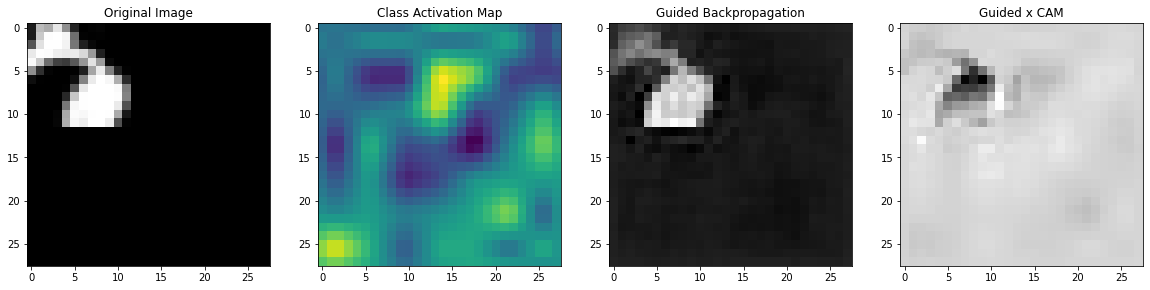

tensor(4, device='cuda:0')


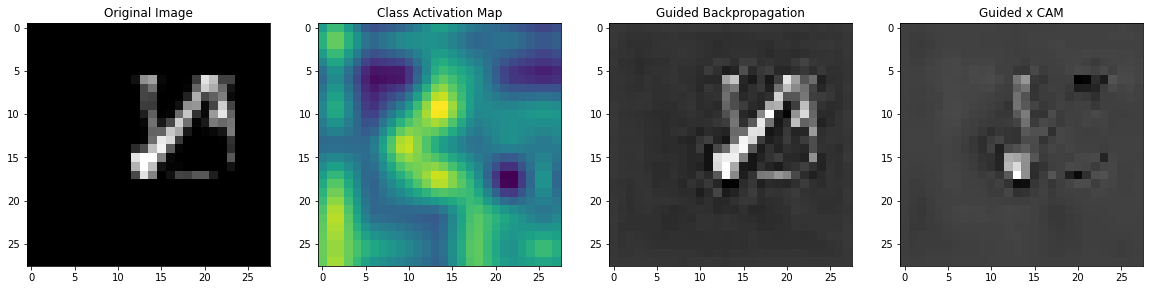

tensor(9, device='cuda:0')


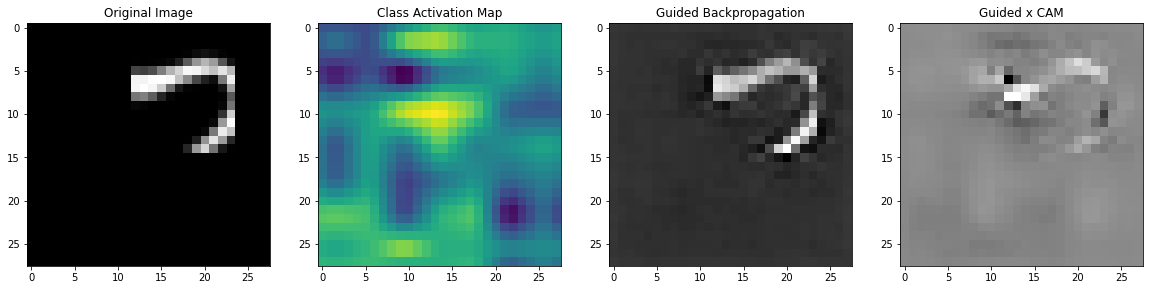

tensor(3, device='cuda:0')


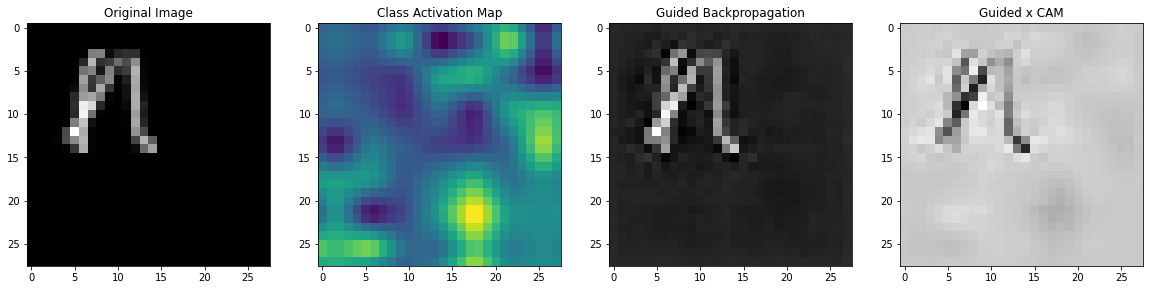

tensor(8, device='cuda:0')


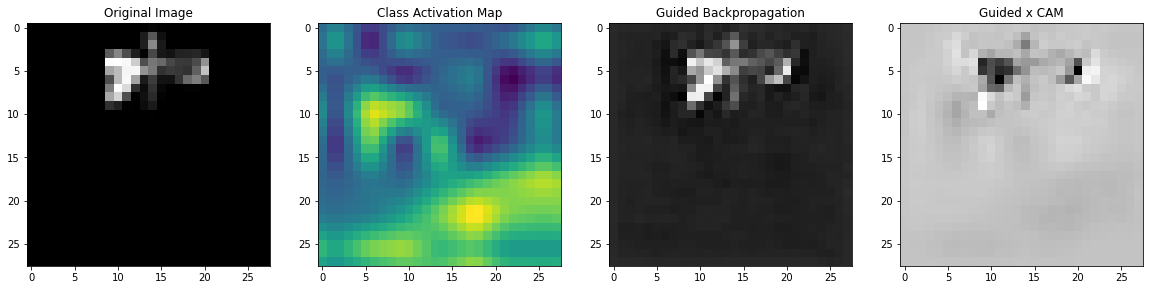

tensor(0, device='cuda:0')


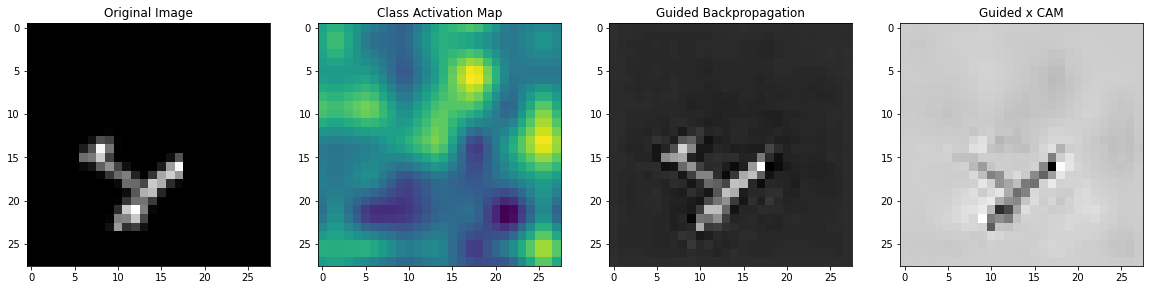

tensor(9, device='cuda:0')


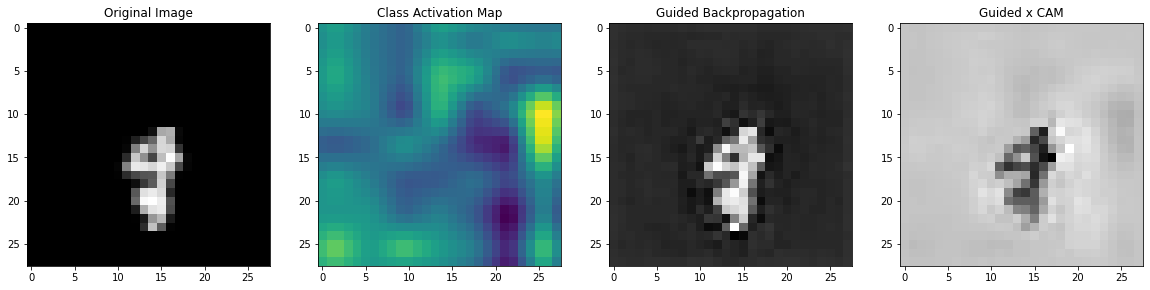

tensor(6, device='cuda:0')


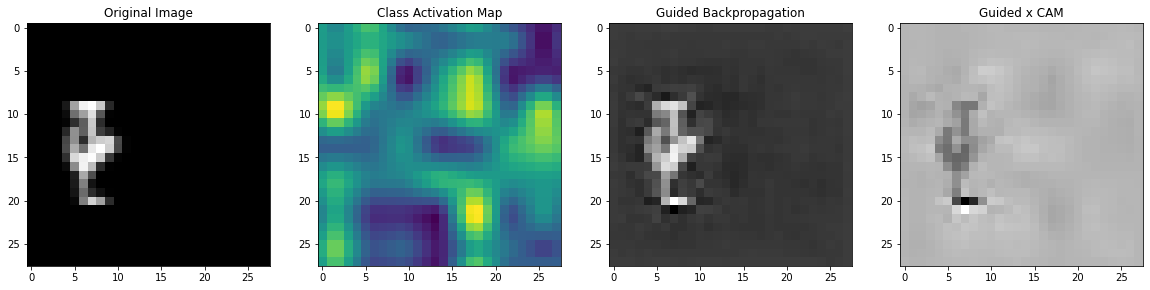

tensor(2, device='cuda:0')


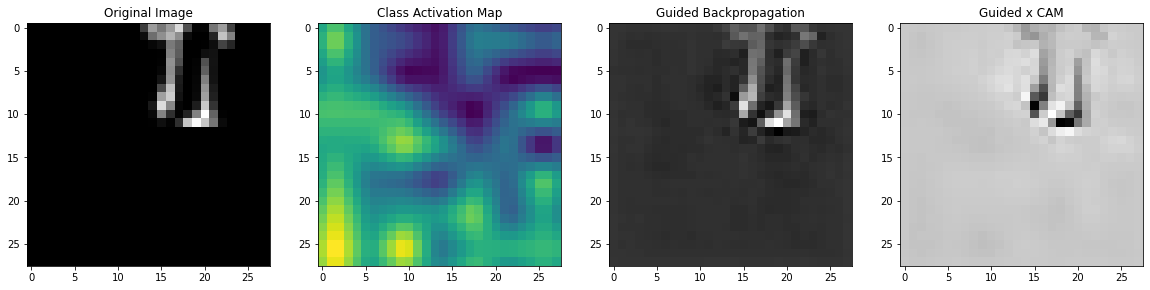

tensor(4, device='cuda:0')


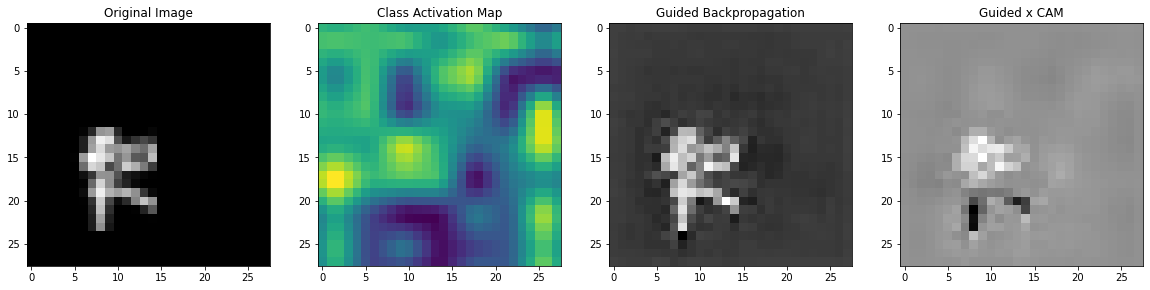

tensor(7, device='cuda:0')


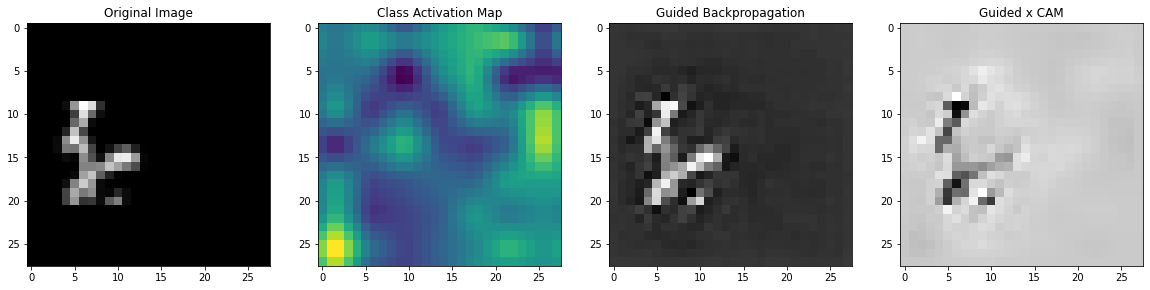

tensor(9, device='cuda:0')


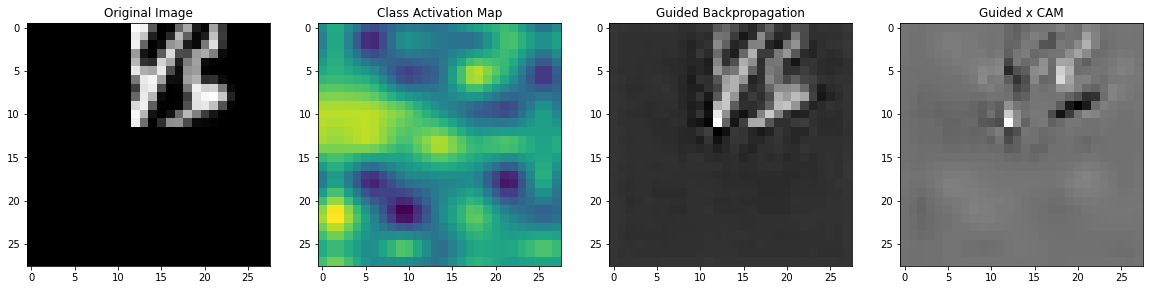

tensor(1, device='cuda:0')


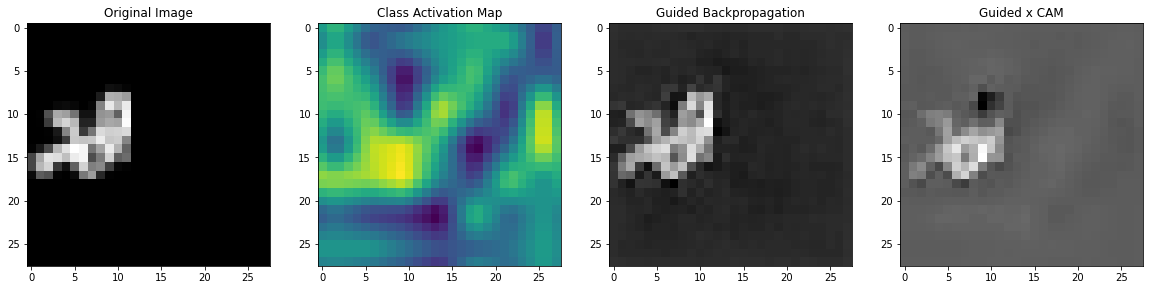

tensor(0, device='cuda:0')


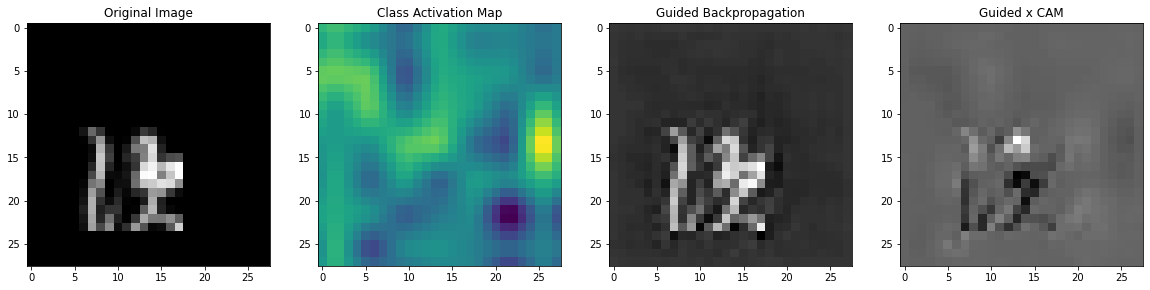

tensor(2, device='cuda:0')


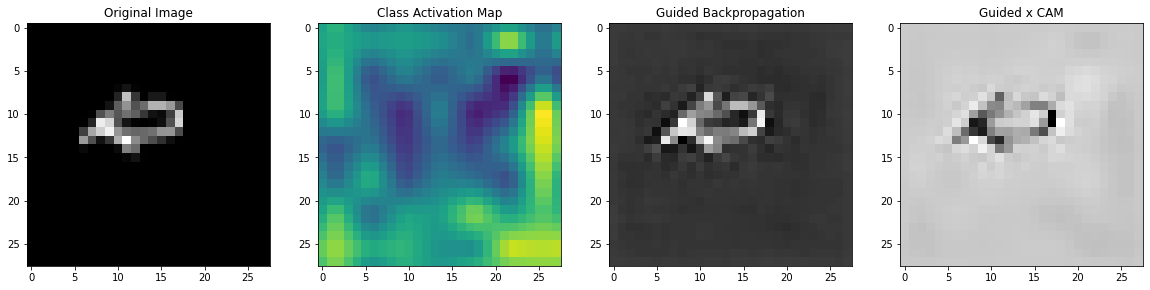

tensor(7, device='cuda:0')


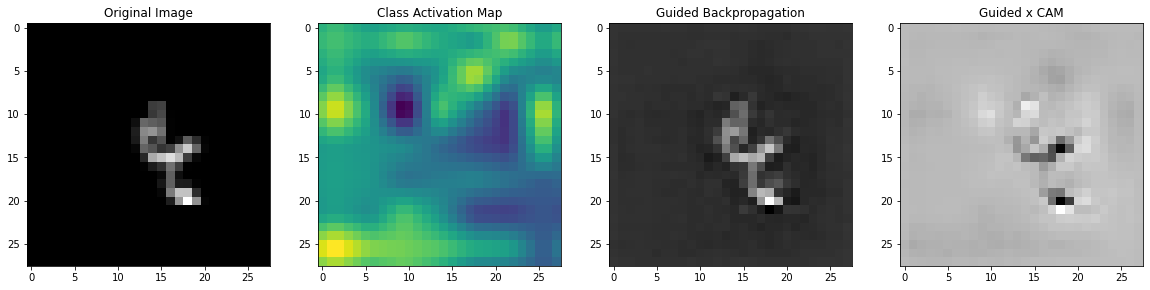

tensor(2, device='cuda:0')


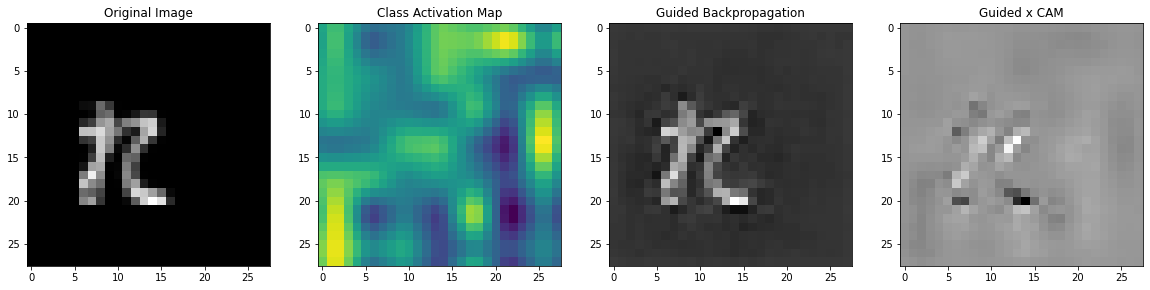

tensor(0, device='cuda:0')


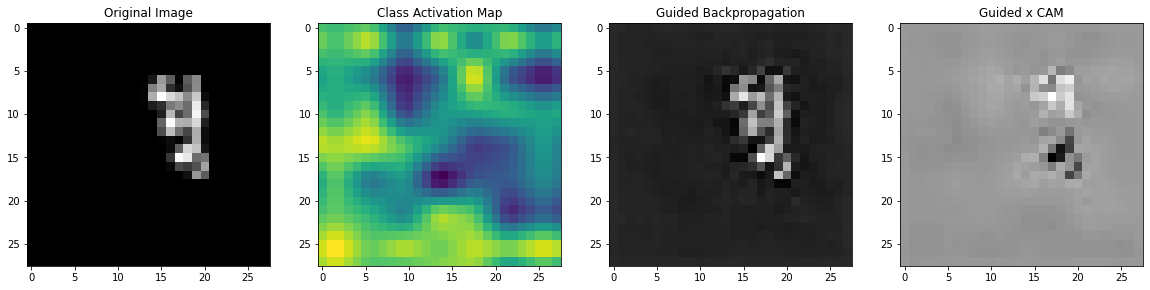

tensor(6, device='cuda:0')


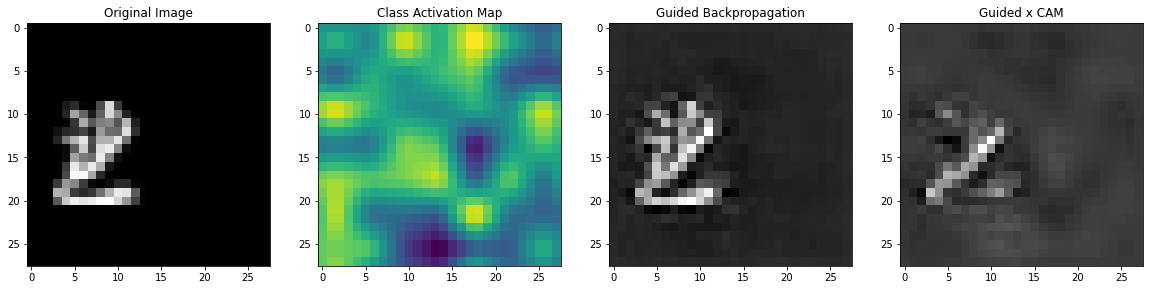

tensor(8, device='cuda:0')


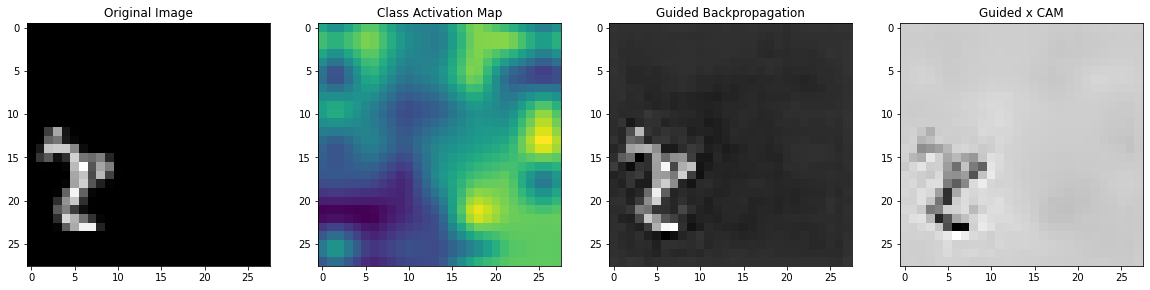

tensor(9, device='cuda:0')


In [67]:
cam = CAM(guide)
guide.reset_output()
for image,label in test_loader:
    x = Variable(image,requires_grad=True).float().cuda()
    y_= Variable(label).cuda()
        
    output = guide.forward(x) 
    output = torch.index_select(output,dim=1,index=y_)
    output = torch.sum(output)
    output.backward(retain_graph=True)
    
    for j in range(20):
        out = cam.get_cam(j)
        guided_img = guide.get_visual(j,x)
        cam.visualize(out,guided_img,x[j])
        print(y_[j])
        
    break